### In this notebook I combine historical flight data with weather data to classify whether or not a flight will be delayed. The flight data is from the Bureau of Transportation Statistics, and the weather data is from the National Oceanic and Atmospheric Administration. I focus on one route, from JFK to LAX due to the difficulty in obtaining weather data. 

In [52]:
import pickle 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn import metrics
%matplotlib inline

# Read in Flight Data

In [53]:
df = pd.read_csv('JAN.csv')
for month in ['FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL' ,'AUG', 'SEP', 'OCT', 'NOV', 'DEC']:
    df = pd.concat([df, pd.read_csv(month+'.csv')])

In [54]:
df['ROUTE']=df['ORIGIN']+df['DEST']
df.groupby(['ROUTE']).count().sort_values('DAY_OF_WEEK', ascending=False).head(10)

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,...,DEP_TIME_BLK,CRS_ARR_TIME,ARR_DEL15,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,Unnamed: 20
ROUTE,,,,,,,,,,,,,,,,,,,,,
SFOLAX,17729,17729,17729,17729,17729,17729,17729,17729,17729,17729,...,17729,17729,17304,17729,17729,17729,17729,5096,5096,0
LAXSFO,17382,17382,17382,17382,17382,17382,17382,17382,17382,17382,...,17382,17382,16950,17382,17382,17382,17382,5194,5194,0
LAXJFK,12487,12487,12487,12487,12487,12487,12487,12487,12487,12487,...,12487,12487,12357,12487,12487,12487,12487,2662,2662,0
JFKLAX,12485,12485,12485,12485,12485,12485,12485,12485,12485,12485,...,12485,12485,12379,12485,12485,12485,12485,2196,2196,0
LAXLAS,11407,11407,11407,11407,11407,11407,11407,11407,11407,11407,...,11407,11407,11300,11407,11407,11407,11407,2702,2702,0
LASLAX,11380,11380,11380,11380,11380,11380,11380,11380,11380,11380,...,11380,11380,11282,11380,11380,11380,11380,3377,3377,0
SEALAX,10208,10208,10208,10208,10208,10208,10208,10208,10208,10208,...,10208,10208,10168,10208,10208,10208,10208,1814,1814,0
LAXSEA,10188,10188,10188,10188,10188,10188,10188,10188,10188,10188,...,10188,10188,10143,10188,10188,10188,10188,1693,1693,0
LGAORD,10045,10045,10045,10045,10045,10045,10045,10045,10045,10045,...,10045,10045,9805,10045,10045,10045,10045,1926,1926,0


# Subset on flights from JFK to LAX
### This is the 4th busiest route, and is much longer distance and likely carries more total passengers than the SFO to LAX route.

In [55]:
df=df[df['ROUTE']=='JFKLAX']
df=df[['DAY_OF_WEEK', 'FL_DATE', 'UNIQUE_CARRIER', 'ORIGIN',\
      'DEST', 'DEP_TIME_BLK', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME', 'DISTANCE', 'ARR_DEL15']]
df=df.dropna()

In [56]:
df['ARR_DEL15']=df['ARR_DEL15'].apply(lambda x: int(x))
num_delays = df[df['ARR_DEL15']==1].shape[0]
num_flights = df.shape[0]
print('number of delays', num_delays, 'number of flights', num_flights, 'percent delayed', num_delays/num_flights)

number of delays 2196 number of flights 12379 percent delayed 0.17739720494385652


#### This route experiences about the same percentage of delays as the nationwide average (17%).
#### There are four carriers servicing this route, with American Airlines making twice as many trips as Virgin, annually.

In [57]:
df.groupby(['UNIQUE_CARRIER']).count()

,DAY_OF_WEEK,FL_DATE,ORIGIN,DEST,DEP_TIME_BLK,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,ARR_DEL15
UNIQUE_CARRIER,,,,,,,,,
AA,4120,4120,4120,4120,4120,4120,4120,4120,4120
B6,3126,3126,3126,3126,3126,3126,3126,3126,3126
DL,3063,3063,3063,3063,3063,3063,3063,3063,3063
VX,2070,2070,2070,2070,2070,2070,2070,2070,2070


# Read in and clean weather data

#### Due to differences in the reporting of the data at JFK and LAX, the CSVs are in slightly different formats. Below we see the differences in the weather in LA and NYC that we expected. Notice, for example, that there was no snow reported at LAX, while there were 30 inches reported one day at JFK.

In [58]:
def read_LA_data():
    LA = pd.read_csv('LA.csv')
    cols = ['date', 'wind_speed','gusts','sky_cover','visibility', 'temperature','high_temp', \
            'low_temp', 'precip_hour', 'precip_6hour', 'precip_24hour', 'snow']
    LA = LA[['YR--MODAHRMN', 'SPD', 'GUS', 'SKC', 'VSB', \
                       'TEMP', 'MAX', 'MIN', 'PCP01', 'PCP06', 'PCP24', 'SD']]
    LA.columns = cols
    return LA


def read_JFK_data():
    JFK=pd.read_csv('JFK.csv')
    cols = ['date', 'wind_speed','gusts','sky_cover','visibility', 'temperature','high_temp', \
            'low_temp', 'precip_hour', 'precip_6hour', 'precip_24hour', 'snow']
    JFK=JFK[[2,4,5,7,11,21,26,27,28,29,30,32]]
    JFK.columns=cols
    return JFK


def remove_stars(x):
    if '*' in str(x):
        return np.nan
    else:
        return x
    
    
def remove_letters(x):
    x=str(x)
    if x[len(x)-1]=='T':
        return x[:len(x)-1]
    if x[0]=='T':
        return x[1:]
    else:
        return x

    
def clean_airport_data(df):
    for col in list(df.columns):
        df[col]=df[col].apply(remove_stars)
        
    for col in ['date', 'wind_speed','gusts','sky_cover','visibility', 'temperature','high_temp', \
            'low_temp', 'precip_hour', 'precip_6hour', 'precip_24hour', 'snow']:
        df[col]=df[col].apply(remove_stars)
    
    for col in ['wind_speed', 'gusts','visibility','temperature','high_temp','low_temp']:
        df[col]=df[col].apply(float)
    
    for col in ['precip_hour', 'precip_6hour','precip_24hour','snow']:
        df[col]=df[col].apply(remove_letters)
        
    for col in ['precip_hour', 'precip_6hour','precip_24hour','snow']:
        df[col]=df[col].apply(float)
    return df

In [59]:
LA = read_airport_data('LA')
LA = clean_airport_data(LA)
print(LA.shape[0])
LA.head()

11036


,date,wind_speed,gusts,sky_cover,visibility,temperature,high_temp,low_temp,precip_hour,precip_6hour,precip_24hour,snow
0,201512010000,13.0,NaN,SCT,10.0,62.0,66.0,46.0,NaN,NaN,NaN,NaN
1,201512010053,10.0,NaN,SCT,10.0,61.0,NaN,NaN,0.0,NaN,NaN,NaN
2,201512010153,11.0,NaN,SCT,10.0,60.0,NaN,NaN,0.0,NaN,NaN,NaN
3,201512010253,8.0,NaN,SCT,10.0,61.0,NaN,NaN,0.0,NaN,NaN,NaN
4,201512010353,6.0,NaN,CLR,10.0,60.0,NaN,NaN,0.0,NaN,NaN,NaN


In [60]:
LA.describe()

/Users/michaelcantrell/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,date,wind_speed,gusts,visibility,temperature,high_temp,low_temp,precip_hour,precip_6hour,precip_24hour,snow
count,1.103600e+04,10670.000000,373.000000,10670.000000,10658.000000,3596.000000,3225.000000,8752.000000,160.000000,436.000000,0.0
mean,2.015983e+11,7.376476,25.142091,8.939363,64.062019,69.659622,59.571783,0.000997,0.106437,0.054106,NaN
std,2.611992e+07,5.155877,6.965250,2.165995,7.271579,7.730139,6.898943,0.013214,0.192603,0.180011,NaN
min,2.015120e+11,0.000000,16.000000,0.000000,40.000000,50.000000,39.000000,0.000000,0.000000,0.000000,NaN
25%,2.016030e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.016060e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.016083e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2.016113e+11,41.000000,54.000000,10.000000,100.000000,101.000000,91.000000,0.480000,1.030000,1.420000,NaN


In [61]:
JFK = read_JFK_data()
JFK=clean(JFK)
JFK.head()

,date,wind_speed,gusts,sky_cover,visibility,temperature,high_temp,low_temp,precip_hour,precip_6hour,precip_24hour,snow
0,201512010051,9.0,NaN,NaN,10.0,44.0,NaN,NaN,0.0,NaN,NaN,NaN
1,201512010151,10.0,NaN,NaN,10.0,44.0,NaN,NaN,0.0,NaN,NaN,NaN
2,201512010251,8.0,NaN,NaN,10.0,45.0,NaN,NaN,0.0,NaN,NaN,NaN
3,201512010300,8.0,NaN,OVC,10.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
4,201512010351,8.0,NaN,NaN,10.0,46.0,NaN,NaN,0.0,NaN,NaN,NaN


In [62]:
JFK.describe()

/Users/michaelcantrell/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,date,wind_speed,gusts,visibility,temperature,high_temp,low_temp,precip_hour,precip_6hour,precip_24hour,snow
count,1.206700e+04,11702.000000,1607.000000,11702.000000,11702.000000,3300.000000,2912.000000,8701.000000,659.000000,588.000000,518.000000
mean,2.015982e+11,11.134336,28.362788,9.362870,57.506324,60.823636,50.344780,0.003816,0.101669,0.172670,2.992278
std,2.634743e+07,6.191354,6.171052,2.011579,16.220747,15.793217,15.066848,0.030024,0.217752,0.339128,6.766336
min,2.015120e+11,0.000000,16.000000,0.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.016030e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.016060e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.016083e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2.016113e+11,43.000000,54.000000,10.000000,97.000000,98.000000,93.000000,1.450000,2.420000,2.900000,30.000000


### Fill in the NaNs in an intelligent way on a column by column basis

In [63]:
for col in ['wind_speed','gusts','precip_hour','precip_6hour','precip_6hour','precip_24hour','snow']:
    JFK[col]=JFK[col].replace('NaN', 0.0)
    LA[col]=LA[col].replace('NaN', 0.0)

for col in ['wind_speed','visibility','temperature','high_temp', 'low_temp']:
    JFK[col]=JFK[col].replace('NaN', JFK[col].median())
    LA[col]=LA[col].replace('NaN', LA[col].median())

### Format date and time in order to merge with flight data

In [64]:
def format_date(x):
    x=str(x)
    return x[:4] + "-" + x[4:6] + "-" + x[6:8] + " " + x[8:]

JFK['date']=JFK['date'].apply(format_date)
LA['date']=LA['date'].apply(format_date)

# Feature engineering
## First I engineer origin and destination 'congestion'

In [65]:
# get totals for date, origin airport and departure hour window
df_origin =df.groupby(['FL_DATE','ORIGIN','DEP_TIME_BLK']).size().reset_index()

# get totals for date, destination airport and arrival hour window
df_dest=df.groupby(['FL_DATE','DEST','ARR_TIME_BLK']).size().reset_index()

# merge these totals with df
df=df.merge(df_origin, on=['FL_DATE','ORIGIN','DEP_TIME_BLK'], how='left')
df=df.merge(df_dest, on=['FL_DATE','DEST','ARR_TIME_BLK'], how='left')

# rename columns
df = df.rename(columns={'0_x': 'ORIGIN_CONG', '0_y': 'DEPART_CONG'})

# find median for number of flights out of airport during hour window.
# TODO in retrospect, should have grouped by 'dest', 'arr_time_blk' when computing median for depart_cong.
df_medians=df.groupby(['FL_DATE','ORIGIN','DEP_TIME_BLK'],as_index=False)['ORIGIN_CONG','DEPART_CONG'].median()

# merge congestion information with df
df=df.merge(df_medians, on=['FL_DATE','ORIGIN','DEP_TIME_BLK'], how='left')
df = df.rename(columns={'ORIGIN_CONG_x': 'ORIGIN_CONG', 'DEPART_CONG_x': 'DEPART_CONG', \
                        'ORIGIN_CONG_y':'MED_ORIGIN_CONG', 'DEPART_CONG_y':'MED_DEPART_CONG'})

# add month feature 
df['MONTH']=df['FL_DATE'].apply(lambda x: x.split('-')[1])

df.head()

,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME_BLK,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,ARR_DEL15,ORIGIN_CONG,DEPART_CONG,MED_ORIGIN_CONG,MED_DEPART_CONG,MONTH
0,1,2016-01-04,AA,JFK,LAX,0900-0959,1200-1259,385.0,2475.0,0,3,3,3.0,3.0,01
1,1,2016-01-11,AA,JFK,LAX,0900-0959,1200-1259,394.0,2475.0,0,3,3,3.0,3.0,01
2,1,2016-01-18,AA,JFK,LAX,0900-0959,1200-1259,394.0,2475.0,0,3,3,3.0,3.0,01
3,1,2016-01-25,AA,JFK,LAX,0900-0959,1200-1259,394.0,2475.0,0,2,2,2.0,2.0,01
4,1,2016-01-04,AA,JFK,LAX,1200-1259,1500-1559,378.0,2475.0,0,3,3,3.0,3.0,01


## Prepare data to be fed in to sklearn

In [66]:
Y=df['ARR_DEL15']
X=df.drop('ARR_DEL15',axis=1)

### Add one more feature - the 'adjusted congestion'

In [67]:
X['ORIGIN_CONG_DIFF']=X['ORIGIN_CONG']-X['MED_ORIGIN_CONG']
X['DEPART_CONG_DIFF']=X['DEPART_CONG']-X['MED_DEPART_CONG']

###  Make dummy variables where appropriate

In [68]:
X=df[['CRS_ELAPSED_TIME','DISTANCE','ORIGIN_CONG','DEPART_CONG','MED_ORIGIN_CONG','MED_DEPART_CONG', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK','ARR_TIME_BLK', 'MONTH']]
X=pd.get_dummies(X, columns=['DAY_OF_WEEK', 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME_BLK','ARR_TIME_BLK', 'MONTH'])
X=pd.DataFrame(preprocessing.normalize(X, axis=0))

# Make and evalute models
### For Random Forest, Logistic Regression and KNN, I perform a grid search on several hyper-parameters and optimize for area under the ROC curve. I also use Naive Bayes. In a previous notebook I made linear and rbf SVM models, but they were too computationally expensive to be investigated in great detail, so I left them out of the final analysis.

In [119]:
def eval_model(X,Y, algo): #use for more computationally intensive algorithms
    ''' Given X, Y, an sklearn classifier algorithm and a ratio, show plot of roc curve and return \
    area under roc curve, test and train score on a single test/train split'''
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    model=algo.fit(X_train,Y_train)
        
    probs=model.predict_proba(X_test)
    scores=[p[1] for p in probs]
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, scores, pos_label=1)

    return roc_auc_score(Y_test,scores), model.score(X_test,Y_test), model.score(X_train_res,Y_train_res)
    plt.plot(fpr, tpr)
    x=np.arange(0,1.1,.1)
    plt.plot(x,x)

In [ ]:
def eval_model_ROS_cv(X,Y, algo, rat=0.6, n=5): #use cv for less computationally intensive algorithms
    ''' Given X, Y, an sklearn classifier algorithm, a ratio and n_folds, show plot of roc curve and return \
    mean of area under roc curve, test and train score on a n_fold single test/train split'''
    
    kf = KFold(n=len(X), n_folds=n, shuffle=True)
    roc=[]
    test_score=[]
    train_score=[]
    for train, test in kf:
        X_train=X.iloc[train]
        Y_train=Y.iloc[train]
        X_test=X.iloc[test]
        Y_test=Y.iloc[test]
        ros = RandomOverSampler(ratio=rat)
        X_train_res, Y_train_res=ros.fit_sample(X_train, Y_train)
        model=algo.fit(X_train_res,Y_train_res)
        test_score.append(model.score(X_test,Y_test))
        train_score.append(model.score(X_train_res, Y_train_res))
        
        probs=model.predict_proba(X_test)
        scores=[p[1] for p in probs]
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, scores, pos_label=1)
        roc.append(roc_auc_score(Y_test,scores))
        
        plt.plot(fpr, tpr)
        x=np.arange(0,1.1,.1)
        plt.plot(x,x)
    return (sum(roc)/n, sum(test_score)/n, sum(train_score)/n)

## Random Forest

In [60]:
l=[]
for n_est in [10,50,100,200]:
    for max_feat in ['auto', 'log2', .3, .5]:
        for max_dep in [5,10,20]:
            roc,test,train = eval_model_ROS_cv(X,Y, RandomForestClassifier(n_estimators=n_est, \
                                                          max_features=max_feat, max_depth=max_dep))
            l.append([roc,test,train, n_est, max_feat, max_dep])
l.sort(reverse=True)
l

[[0.7223940349961232,
  0.80620368466572023,
  0.74331472675171462,
  100,
  'auto',
  10],
 [0.72189517137813408,
  0.80895145314208317,
  0.73596565385891988,
  200,
  'log2',
  10],
 [0.72117572810119557, 0.79739912860429818, 0.75601878218872398, 100, 0.3, 10],
 [0.72081221643362692,
  0.80515353861718975,
  0.74303781488361664,
  200,
  'auto',
  10],
 [0.72038069187979459, 0.79441027398377972, 0.77129680349777974, 200, 0.5, 10],
 [0.72025664983352011,
  0.80741551214895324,
  0.74322915642448739,
  50,
  'auto',
  10],
 [0.7198184512084127,
  0.81056604820417422,
  0.73804552282808822,
  100,
  'log2',
  10],
 [0.71787854095168702, 0.79885259705292011, 0.75852395998188138, 50, 0.3, 10],
 [0.71716278052339211, 0.79756074476591443, 0.76885897349257504, 100, 0.5, 10],
 [0.71699073471935204,
  0.8058005580848876,
  0.74054612684053089,
  50,
  'log2',
  10],
 [0.71596744129303569, 0.79756032049085357, 0.75844425290028539, 200, 0.3, 10],
 [0.71193391151735819, 0.7916622444150716, 0.771

## Logistic Regression

In [61]:
l2=[]

for pen in ['l1', 'l2']:
    for c in [0.1,1,10, 100]:
        for ratio in [0.4, 0.75, 1.0]:
            l2.append([roc, test, train, pen, c, ratio])
            print(roc, test, train, pen, c, ratio)

l2.sort(reverse=True)
l2

[[0.71456491962961921,
  0.81412013511528869,
  0.74496738825875419,
  'l1',
  100,
  0.4],
 [0.71435213076526449,
  0.72687589954472021,
  0.67731550411853381,
  'l1',
  100,
  0.75],
 [0.71391744289876813,
  0.65998981739854123,
  0.66904164145005451,
  'l1',
  100,
  1.0],
 [0.71077805444556552,
  0.81581625626213672,
  0.74318908237035297,
  'l2',
  100,
  0.4],
 [0.71030449237236648,
  0.65732200845286459,
  0.66503015373779761,
  'l2',
  100,
  1.0],
 [0.71012651441871488,
  0.72816811083370048,
  0.67305042808763416,
  'l1',
  10,
  0.75],
 [0.70992936667263662,
  0.72728180023171951,
  0.67491485977026722,
  'l2',
  100,
  0.75],
 [0.70988571921066801, 0.65918183450008982, 0.66077466938691987, 'l1', 1, 1.0],
 [0.7094056867567875, 0.66144184983926502, 0.66797762818686068, 'l1', 10, 1.0],
 [0.70877449849351226,
  0.81420097583263984,
  0.74397751172854298,
  'l1',
  10,
  0.4],
 [0.70802193916558143,
  0.74537445537768643,
  0.67311240331180211,
  'l1',
  1,
  0.75],
 [0.70790652

## KNN

In [125]:
l3=[]
for k in range(3,20,2):
    for weight in ['uniform', 'distance']:
        l3.append([roc, test, train, k, weight])
        print(roc, test, train)
l3.sort(reverse=True)
l3

[[0.71186934019395942,
  0.81938325991189431,
  0.74202322418663036,
  19,
  'uniform'],
 [0.70321088139440202,
  0.81962799804209496,
  0.74767235066429538,
  13,
  'uniform'],
 [0.70056301079190353,
  0.82183064121390115,
  0.73972172821424831,
  17,
  'uniform'],
 [0.6828290363187095, 0.82599118942731276, 0.74558008159849354, 15, 'uniform'],
 [0.68024719273606848, 0.82085168869309844, 0.75258918296892985, 9, 'uniform'],
 [0.67913798233284428,
  0.81008321096426827,
  0.75185688879589918,
  11,
  'uniform'],
 [0.67140090217359538, 0.81179637787567305, 0.76053980541897692, 7, 'uniform'],
 [0.65030636623277382, 0.81669114047968672, 0.76577047808348153, 5, 'uniform'],
 [0.63256461605857683, 0.8015173764072443, 0.78198556334344593, 3, 'uniform'],
 [0.62761033395805688,
  0.79295154185022021,
  0.80541897688042685,
  13,
  'distance'],
 [0.61951647762466455, 0.79025942241801272, 0.8077204728528089, 5, 'distance'],
 [0.61833500219037474,
  0.79588839941262846,
  0.80949890155874049,
  7,
 

## Naive Bayes

0.683949730024 0.37474953085 0.506436648636


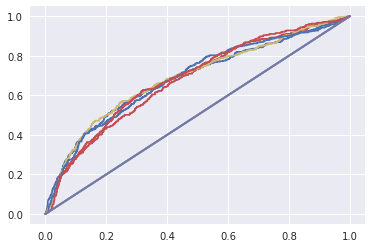

In [63]:
from sklearn.naive_bayes import GaussianNB
roc,test,train = eval_model_ROS_cv(X,Y, GaussianNB())
print(roc, test, train)

## Plot best model for each algorithm

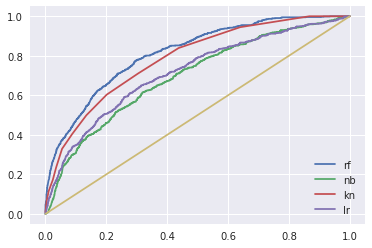

In [126]:
rf=RandomForestClassifier(n_estimators=100, max_features='auto', max_depth=10) 
lr=LogisticRegression(C=100, penalty='l1') #ratio=1.0
nb=GaussianNB()
kn=KNeighborsClassifier(n_neighbors=19, weights='uniform')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

fig, ax = plt.subplots()
### only logistic uses oversampling, so we'll do it last
for algo in [['rf', rf], ['nb', nb], ['kn', kn]]:
    model=algo[1].fit(X,Y)

    probs=model.predict_proba(X_test)
    scores=[p[1] for p in probs]
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, scores, pos_label=1)

    ax.plot(fpr, tpr, label = algo[0])


### now for logistic regression with oversampling
ros = RandomOverSampler(ratio=.4)
X_train_res, Y_train_res=ros.fit_sample(X_train, Y_train)
model=lr.fit(X_train_res,Y_train_res)

probs=model.predict_proba(X_test)
scores=[p[1] for p in probs]
fpr, tpr, thresholds = metrics.roc_curve(Y_test, scores, pos_label=1)

ax.plot(fpr, tpr, label = 'lr')
x=np.arange(0,1.1,.1)
ax.plot(x,x)
legend = ax.legend(loc='lower right', shadow=True, fontsize='medium')

## Random forest performs the best, followed by knn, logistic regression, and then naive Bayes. Because I am interested in interpretability, I will use logistic regression to make a D3 visualization of feature importance.

# Extract coefficients for D3 visualization of feature importance on best Logistic Regression model

In [106]:
ros = RandomOverSampler(ratio=0.4)
X_ros, Y_ros = ros.fit_sample(X, Y)

model = LogisticRegression(C=100, penalty='l1').fit(X_ros,Y_ros)
coefs=model.coef_
coefs[0]

array([ -7.90611831e+02,   0.00000000e+00,  -1.50721500e+01,
         0.00000000e+00,  -1.15309130e+01,  -3.07258061e+00,
         2.98736518e+00,  -1.61206759e+01,  -2.43441642e+01,
         0.00000000e+00,   1.36415430e+00,  -1.20910307e+01,
         4.41522932e-01,   2.02505157e+01,  -1.54177549e-01,
         1.48170947e+01,  -1.19046328e+01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.36157324e+01,
        -1.03649284e+00,   5.71865989e+00,  -9.42963695e+00,
        -1.43154272e+01,  -6.37049388e+00,   1.94765466e+01,
         2.94524454e+00,  -1.23764052e+01,  -3.08586346e+01,
        -1.54828409e+01,  -1.85300549e+01,   0.00000000e+00,
         2.76354054e+01,   3.84897106e+01,   5.90943040e+01,
         4.00316554e+01,  -2.72803879e+01,   2.96979248e+00,
        -1.88803537e+01,   0.00000000e+00,  -4.11185499e+00,
         3.06268300e+00,   1.21265354e+01,   2.55318170e+00,
        -2.49048474e+01,   0.00000000e+00,  -5.22258001e+00,
         2.36754106e+01,

In [109]:
l=list(zip(X.columns, coefs[0]))
df_coef=pd.DataFrame(l)
df_coef

,0,1
0,0,-790.611831
1,1,0.000000
2,2,-15.072150
3,3,0.000000
4,4,-11.530913
5,5,-3.072581
6,6,2.987365
7,7,-16.120676
8,8,-24.344164
9,9,0.000000


In [ ]:
#df_coef.to_csv('coef.csv')